# COMP5329 - Deep Learning
## Assignment 2 - Multilabel Classification

*   Nirav Desai
*   Rebecca Chan

## Initial Set up
### Load packages

In [ ]:
## Load libraries
import re, os
import pandas as pd
from io import StringIO
from google.colab import drive

%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import itertools
import os
import pandas as pd
import seaborn as sns

from torchvision import datasets, transforms
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from torch import optim
import torchvision.models as models
from sklearn.metrics import classification_report, multilabel_confusion_matrix, coverage_error

torch.__version__

'1.8.1+cu101'

##### Use GPU if available

In [ ]:
use_cuda = True if torch.cuda.is_available() else False
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

We are using GPU.


##### Mount google drive

In [ ]:
drive.mount('/content/gdrives')
data_path = '/content/gdrives/MyDrive/COMP5329/COMP5329S1A2Dataset'

Mounted at /content/gdrives


In [ ]:
train_set = '/content/gdrives/MyDrive/COMP5329/COMP5329S1A2Dataset/train.csv'
with open(train_set) as train: 
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train]
  df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

df_train.head()


,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


## Load Dataset Function

**Inputs:**
  1. Root Directory for Images
  2. csv filename with annotations
  3. Pytorch transform object

**Outputs:**
  - Training and Validation Set
    - tuple with image as a tensor and corresponding target One-Hot encoded label as tensor (image, label)
  - Test Set
    - image as a tensor

In [ ]:
class load_data(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        with open(root_dir+'/'+annotation_file) as train: 
          lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train]
          train_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')

        self.root_dir = root_dir
        self.annotations = train_labels
        self.transform = transform


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir+'/data', img_id)).convert("RGB")
        split_label = self.annotations.iloc[index, 1].split()
        num_labels = list(map(int, split_label))
        label = torch.LongTensor(num_labels) - 1
        one_hot_labels = torch.zeros(size=([19]), dtype=torch.float32)
        # print(label, self.one_hot_labels.shape, label.shape)
        y_label = one_hot_labels.scatter_(dim=0, index=label, value=1.)
        # y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [ ]:
# For TEST data

class load_test_data(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None): 
        with open(root_dir + '/' + annotation_file) as test: 
          lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in test]
          test_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')    

        self.root_dir = root_dir
        self.annotations = test_labels
        self.transform = transform
      
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index,0]
        img = Image.open(os.path.join(self.root_dir+'/data', img_id)).convert("RGB")

        if self.transform is not None: 
            img = self.transform(img)

        return (img)

## Image Pre-processing and Augmentation

- Augmentation Techniues such as:
  - Crop
  - Resize
  - Flipping (Horizontal and Vertical)
  - Rotation
  - Brightness Changes
- Normalize
- Load raw data and split into Training and Validation
- Create pytorch DataLoader instance for Train, Validation and Test set

In [ ]:
# https://stackoverflow.com/questions/56774582/adding-custom-labels-to-pytorch-dataloader-dataset-does-not-work-for-custom-data (for adding labels)
# https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc (maybe better?)
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html try this

# DataLoader Parameters
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
kwargs['batch_size'] = 16  # Batch size used during training.
shuffle=True
batch_size = 128
num_workers = 2
pin_memory = True

# Transform for data pre-processing
transform = transforms.Compose([transforms.Resize(240), 
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(degrees=[-30, 30]),
                                transforms.ColorJitter(brightness=0.4),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.48216, 0.44653), (0.24703, 0.24349, 0.26159))
                                ])

# raw_dataset = load_data(data_path,"train_1100.csv",transform=transform)
# raw_dataset = load_data(data_path,"train_100.csv",transform=transform)
raw_dataset = load_data(data_path,"train.csv",transform=transform)

# Train - Validation split
total_raw_data = len(raw_dataset)
train_valid_split = 0.2 ## Creating a small dataset to work on... (only using 20% of samples as training until model is finalised)
valid_record_size = int(train_valid_split * total_raw_data)
train_record_size = int(total_raw_data - valid_record_size)
print(train_record_size, valid_record_size)

train_set, validation_set = torch.utils.data.random_split(raw_dataset, [train_record_size,valid_record_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           shuffle=shuffle, 
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           pin_memory=pin_memory)

validation_loader = torch.utils.data.DataLoader(dataset=validation_set, 
                                                shuffle=shuffle, 
                                                batch_size=batch_size,
                                                num_workers=num_workers, 
                                                pin_memory=pin_memory)

print('Dataloaders initialized.')

images, labels = next(iter(train_loader))
_, _ = next(iter(validation_loader))

print('Shape of an image batch:', images.size())

# Should be approx. 40,000 images (30,000 for training, 10,000 for testing)
print('No. images loaded: ',len(train_loader)*batch_size)


23997 5999
Dataloaders initialized.
Shape of an image batch: torch.Size([128, 3, 224, 224])
No. images loaded:  24064


In [ ]:
# print a batch of labels
print(labels.size())

torch.Size([128, 19])


## Exploratory Dataset Analysis

#### Training Labels

In [ ]:
a = raw_dataset.annotations['Labels'][train_set.indices]
type(a)
b=a.str.split()
c=b.explode().value_counts()
c.index = c.index.astype(int)
print(type(c))
# print(a[1], b[1])
d = c.sort_index()
print(d)
e = d.to_numpy()
print(e)
# f = np.insert(e,8,0) # for missing label 9, inserting 0
f = np.insert(e,11,0) # for missing label 12, inserting 0
print(f, len(f))


<class 'pandas.core.series.Series'>
1     18213
2       912
3      3503
4      1014
5       883
6      1106
7       968
8      1743
9       851
10     1140
11      488
13      511
14      197
15     1543
16      859
17     1158
18     1190
19      828
Name: Labels, dtype: int64
[18213   912  3503  1014   883  1106   968  1743   851  1140   488   511
   197  1543   859  1158  1190   828]
[18213   912  3503  1014   883  1106   968  1743   851  1140   488     0
   511   197  1543   859  1158  1190   828] 19


#### Weight calculation per sample class

In [ ]:
class_counts = f
num_samples = sum(class_counts)

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
# weights = [class_weights[labels_temp[i]] for i in range(int(num_samples))]
# class_weights[8] = 0
class_weights[11] = 0
print(type(class_weights),class_weights)
smp = np.array(class_weights)
print(type(smp),smp)
sss = torch.from_numpy(smp).float().to(dev)
print(type(sss),sss)


<class 'list'> [2.0373908746499754, 40.6875, 10.5929203539823, 36.594674556213015, 42.0237825594564, 33.550632911392405, 38.33367768595041, 21.289156626506024, 43.60399529964747, 32.55, 76.0389344262295, 0, 72.61643835616438, 188.36040609137055, 24.04860661049903, 43.19790454016298, 32.0440414507772, 31.18235294117647, 44.81521739130435]
<class 'numpy.ndarray'> [  2.03739087  40.6875      10.59292035  36.59467456  42.02378256
  33.55063291  38.33367769  21.28915663  43.6039953   32.55
  76.03893443   0.          72.61643836 188.36040609  24.04860661
  43.19790454  32.04404145  31.18235294  44.81521739]
<class 'torch.Tensor'> tensor([  2.0374,  40.6875,  10.5929,  36.5947,  42.0238,  33.5506,  38.3337,
         21.2892,  43.6040,  32.5500,  76.0389,   0.0000,  72.6164, 188.3604,
         24.0486,  43.1979,  32.0440,  31.1824,  44.8152], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  """


#### Training Label Distribution

<BarContainer object of 19 artists>

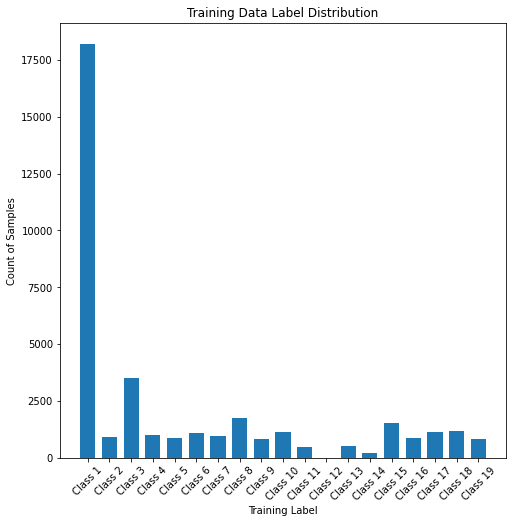

In [ ]:
%matplotlib inline
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10', 'Class 11', 'Class 12', 'Class 13', 'Class 14', 'Class 15', 
'Class 16', 'Class 17', 'Class 18','Class 19']
plt.rcParams['figure.figsize'] = [8, 8]
plt.title('Training Data Label Distribution')
plt.ylabel('Count of Samples')
plt.xlabel('Training Label')
plt.xticks(np.arange(0,19,1), class_labels, rotation=45)
plt.bar(np.arange(len(class_counts)),class_counts, width=0.7)


In [ ]:
def calc_label_weights(n_classes, samples_classes, pw=1):
    label_weightage = 1.0 / np.array(np.power(samples_classes, pw))
    label_weightage = label_weightage / np.sum(label_weightage) * n_classes
    return label_weightage



#### Display Sample Images after Pre-processing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 0
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.])


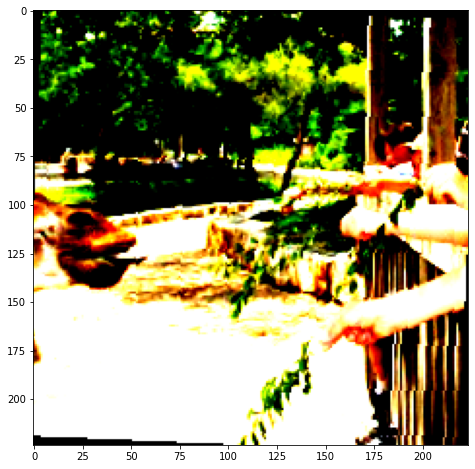

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 1
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


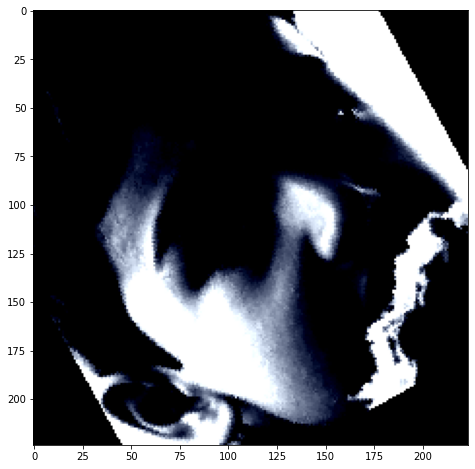

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 2
image label : tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


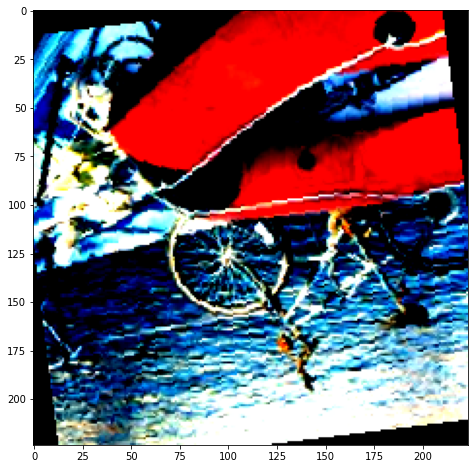

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 3
image label : tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.])


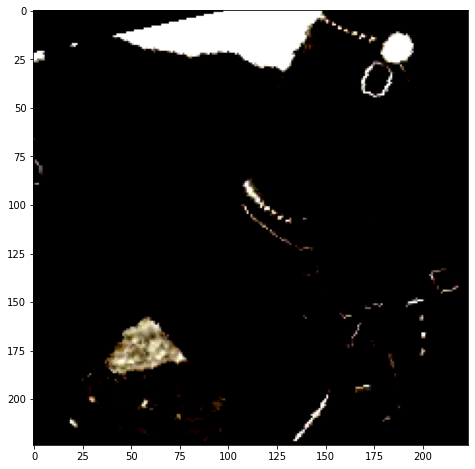

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 4
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


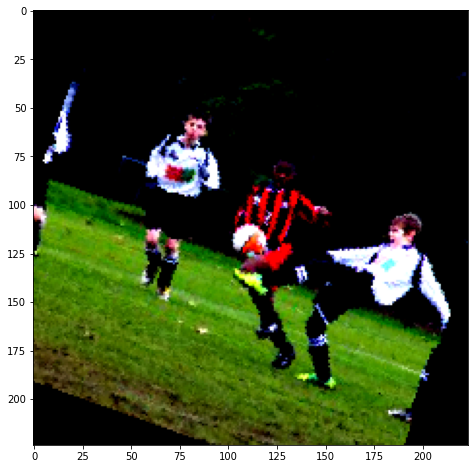

done!


In [ ]:
## Reconstruct some images -- note: images have been normalised 
for i in range(5):
    print('index : {}'.format(i))
    print('image label : {}'.format(labels[i]))
    npimg = images[i].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print('done!')

## Modelling stage:

##### Removing gradients for re-training and ignoring pre-trained gradients

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Implement a simple NN for testing 
feature_extract = True

##### Pre-trained Resnext50_32X4d

In [ ]:
# Implement a simple NN for testing 

class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        set_parameter_requires_grad(resnet, feature_extract)

        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

# Inialise base model
model = Resnext50 (19).to(dev)



Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


#### Create pre-trained DenseNet (121)

In [ ]:
# Implement a simple NN for testing 

class Dense161(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        densenet = models.densenet121(pretrained=True)
        set_parameter_requires_grad(resnet, feature_extract)

        densenet.classifier = nn.Sequential(
            # nn.Dropout(p=0.2),
            nn.Linear(in_features=densenet.classifier.in_features, out_features=n_classes)
        )
        self.base_model = densenet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

# model = Dense161(19).to(dev)

#### Create pre-trained ResNet50

In [ ]:
class Resnet50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        set_parameter_requires_grad(resnet, feature_extract)
        resnet.fc = nn.Sequential(
            # nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))
        # return self.base_model(x)

# model = Resnet50(19).to(dev)

# print(model)
# for param in model.parameters():
#     print(param)

##### Set parameters to update and Optimizer

In [ ]:
params_to_update = model.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
# optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer = optim.Adam(params_to_update, lr=0.001)

summary(model.cuda(), (1,3, 224, 224))

Params to learn:
	 base_model.fc.1.weight
	 base_model.fc.1.bias


Layer (type:depth-idx)                        Output Shape              Param #
Resnext50                                     --                        --
├─ResNet: 1-1                                 [1, 19]                   --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          (63,488)
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          (71,168)
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          (71,168)
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]       

In [ ]:
def accuracy(predicted, original):  
    """
    Calculates the number of labels correctly predicted for each image
    """
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

### Model Training with hypermarameters

In [ ]:
# https://pytorch.org/docs/stable/optim.html
# Switch model to the training mode
criterion = nn.BCEWithLogitsLoss(pos_weight=sss)
model.train()

no_epochs = 30
epoch_loss = []

## Perform training stage 
for epoch in range(no_epochs): 
    print(f'epoch {epoch + 1}')

    start = time.time()
    ep_loss = 0.0
    ep_acc = 0.0
    
    ## Enumerate through data
    for i, (inputs,labels) in enumerate(train_loader, 0):
        # print(i)
        # Get the inputs
        # inputs = inputs.view(-1, 3*224*224)
        inputs = inputs.to(dev)
        labels = labels.to(dev)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        # outputs = model.sigm(outputs) # for BCELoss only - extra sigmoid layer
        # print(outputs)
        loss = criterion(outputs.float(), labels.float())

        preds = outputs
        torch.cuda.empty_cache()
        ep_loss += loss
        ep_acc += accuracy(torch.round(preds).cpu(), labels.cpu())

        loss.backward()
        optimizer.step()
    
    print(f'Loss: {ep_loss/(i+1) :.3f}, Accuracy: {ep_acc/(i+1) :.3f}')
    print(f'time taken to run: {time.time() - start}')
    epoch_loss.append(round(ep_loss.item()/(i+1),2))

epoch 1
Loss: 1.407, Accuracy: 15.074
time taken to run: 6578.237791061401
epoch 2
Loss: 1.336, Accuracy: 15.677
time taken to run: 145.73802947998047
epoch 3
Loss: 1.321, Accuracy: 15.763
time taken to run: 144.65962100028992
epoch 4
Loss: 1.314, Accuracy: 15.798
time taken to run: 146.21641159057617
epoch 5
Loss: 1.309, Accuracy: 15.794
time taken to run: 148.22254920005798
epoch 6
Loss: 1.305, Accuracy: 15.784
time taken to run: 145.7446789741516
epoch 7
Loss: 1.303, Accuracy: 15.822
time taken to run: 143.58684825897217
epoch 8
Loss: 1.301, Accuracy: 15.817
time taken to run: 144.49254417419434
epoch 9
Loss: 1.301, Accuracy: 15.812
time taken to run: 143.98531866073608
epoch 10
Loss: 1.299, Accuracy: 15.870
time taken to run: 143.08979153633118
epoch 11
Loss: 1.297, Accuracy: 15.856
time taken to run: 144.76758790016174
epoch 12
Loss: 1.297, Accuracy: 15.860
time taken to run: 143.19547724723816
epoch 13
Loss: 1.294, Accuracy: 15.845
time taken to run: 143.34982061386108
epoch 14
L

##### Visualise Training Loss

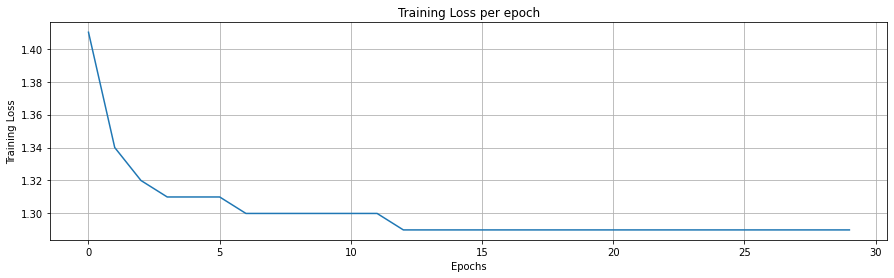

In [ ]:
plt.figure(figsize=(15,4))
plt.title('Training Loss per epoch')
plt.ylabel('Training Loss')
plt.xlabel('Epochs')
plt.plot(epoch_loss)
plt.grid()

In [ ]:
torch.cuda.memory.empty_cache()

### Model Validation on validation set data

In [ ]:
import gc

model.eval()

epoch_loss = 0.0
epoch_accuracy = 0.0
pred_results = np.array(range(1,20)).reshape(1,19)
target_results = np.array(range(1,20)).reshape(1,19)
print(target_results.shape, target_results)

for step, (inputs, label) in enumerate(validation_loader):
    inputs = torch.Tensor.cpu(inputs).to(dev)
    label = torch.Tensor.cpu(label).to(dev)

    y_pred = model(inputs)
    preds_rounded = torch.round(y_pred) #anything greater than prob > 0.5 converted to predicted label
    preds_np = torch.Tensor.cpu(preds_rounded).detach().numpy()
    targets_np = torch.Tensor.cpu(label).detach().numpy()

    pred_results = np.concatenate((pred_results, preds_np), axis=0)
    target_results = np.concatenate((target_results, targets_np), axis=0)

    acc = accuracy(preds_rounded.cpu(), label.cpu())
    torch.cuda.empty_cache()
    
    epoch_loss += criterion(y_pred.float(), label.float())
    epoch_accuracy += acc

print(epoch_loss/(len(validation_loader)))
print(epoch_accuracy/(len(validation_loader)))
print(pred_results.shape, target_results.shape)

(1, 19) [[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]
tensor(1.3011, device='cuda:0', grad_fn=<DivBackward0>)
15.919189967893425
(6000, 19) (6000, 19)


In [ ]:
class_names = np.array(list(range(1, 20)))

### Model evaluation
- Classification Report
- Confusion Matrix for all classes

In [ ]:
classes = [str(i).zfill(2) for i in range(1,20)]
print(class_names, classes)
print(classification_report(target_results[1:], pred_results[1:], target_names=classes , zero_division=1))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
              precision    recall  f1-score   support

          01       0.76      1.00      0.87      4581
          02       0.16      0.62      0.25       250
          03       0.33      0.79      0.47       861
          04       0.24      0.83      0.37       258
          05       0.38      0.91      0.53       247
          06       0.22      0.90      0.35       288
          07       0.28      0.83      0.42       253
          08       0.24      0.81      0.36       467
          09       0.13      0.84      0.22       191
          10       0.23      0.83      0.37       331
          11       0.06      0.90      0.11       116
          12       1.00      1.00      1.00         0
          13       0.12      0.76      0.20        94
          14       0.05      0.85      0.09        54
          15   

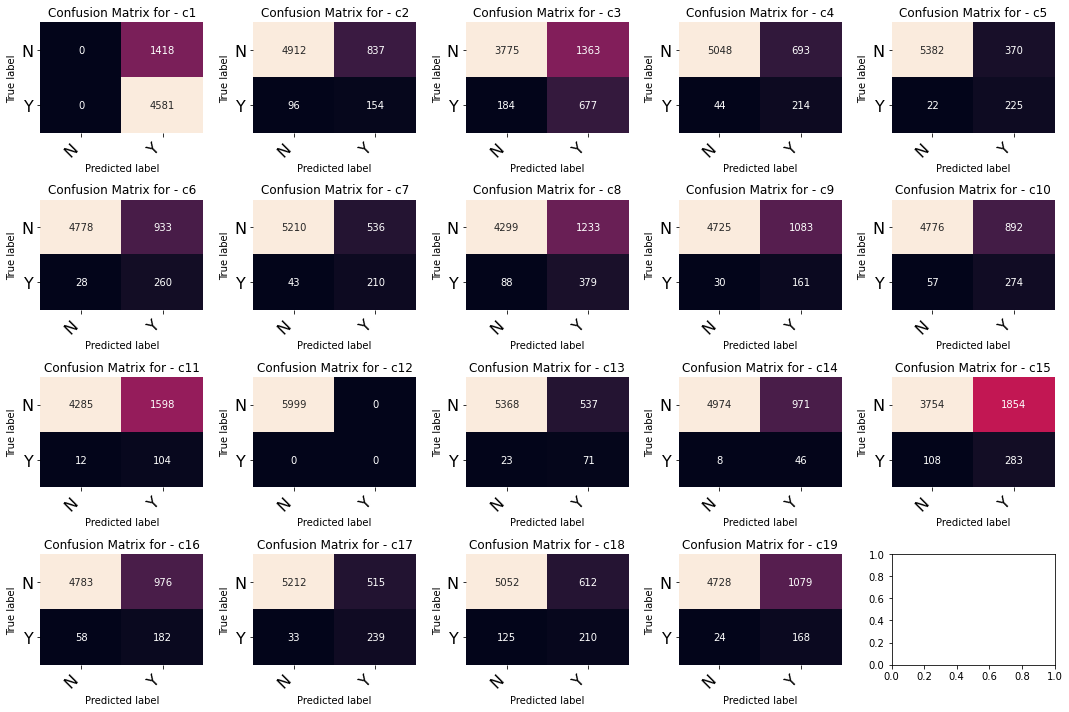

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, coverage_error
multi_matrix = multilabel_confusion_matrix(target_results[1:], pred_results[1:])


labels = ["".join("c" + str(i)) for i in range(1, 20)]

def display_heatmap(confusion_matrix, axes, class_labels, class_names, fontsize=16):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for - " + class_labels)


fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), multi_matrix, labels):
        display_heatmap(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

## Test Prediction
- Initialize test loader
- Run and save predictions

In [ ]:
test_dataset = load_test_data(data_path, "test.csv", transform=transform)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          shuffle = False, 
                                          batch_size = None
                                          )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                shuffle=False, 
                                                batch_size=batch_size,
                                                num_workers=num_workers, 
                                                pin_memory=pin_memory)

test_images = next(iter(test_loader))

print('No. Test images loaded: ',len(test_loader)*batch_size)

No. Test images loaded:  10112


In [ ]:
## Make test predictions
model.eval()
test_pred_results = np.array(range(1,20)).reshape(1,19)
images = []
predictions = []
cnt=0

for step, (test_inputs) in enumerate(test_loader):
    idx = step*batch_size
    images.append(test_dataset.annotations.ImageID[idx:(idx+batch_size)])
    # test_inputs = test_inputs.view(-1, 3*224*224)
    test_inputs = torch.Tensor.cpu(test_inputs).to(dev)

    y_test = model(test_inputs)

    test_preds_rounded = torch.round(y_test) #anything greater than prob > 0.5 converted to predicted label
    test_preds_np = torch.Tensor.cpu(test_preds_rounded).detach().numpy()
    test_pred_results = np.concatenate((test_pred_results, test_preds_np), axis=0)


test_pred_results = test_pred_results[1:]
for result in test_pred_results:
    result_lb = class_names[result == 1.0] 
    preds_string = [str(int) for int in result_lb]
    predictions.append(' '.join(preds_string))


prediction_upload = pd.DataFrame(zip(test_dataset.annotations.ImageID, predictions), columns = ['ImageID', 'Labels'])
prediction_upload.to_csv(data_path + '/alexnet_test_predictions.csv', index = False)
prediction_upload.head()

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1 3 8 15
2,30002.jpg,1 15 18
3,30003.jpg,1 5 8 9 16 19
4,30004.jpg,1 3 11 14 15
